In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel('data_full_5sekres.xlsx')

In [7]:
df1 = df.copy()

In [8]:
#Create a column of load profile
df1['Load'] = df1['thrusterAndPropulsion']
df1.loc[df1['operationId'] == 100, 'BaseLoad'] = 500
df1.loc[df1['operationId'] == 3, 'BaseLoad'] = 550
df1.loc[df1['operationId'] == 5, 'BaseLoad'] = 510
df1.loc[df1['operationId'] == 6, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 1, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 7, 'BaseLoad'] = 380
df1['Load'] = df1['thrusterAndPropulsion'] + df1['BaseLoad']

df1['Battery'] = 0
df1['SOC'] = 0
#Create dataset with only relevant columns
df3 = df1[['datetime', 'Load', 'engMdoPower_0_','engMdoPower_1_','engMdoPower_2_', 'engMdoPower_3_', 'operationId', 'BaseLoad', 'Battery', 'SOC']]

#Set engine powers to zero
num = df3['engMdoPower_0_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_1_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_2_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_3_']._get_numeric_data()
num[num != 0] = 0


display(df3)

,datetime,Load,engMdoPower_0_,engMdoPower_1_,engMdoPower_2_,engMdoPower_3_,operationId,BaseLoad,Battery,SOC
0,2020-01-30 00:00:00,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
1,2020-01-30 00:00:05,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
2,2020-01-30 00:00:10,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
3,2020-01-30 00:00:15,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
4,2020-01-30 00:00:20,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
...,...,...,...,...,...,...,...,...,...,...
120955,2020-02-05 23:59:35,2046.0,0.0,0.0,0,0.0,3.0,550.0,0,0
120956,2020-02-05 23:59:40,1993.2,0.0,0.0,0,0.0,3.0,550.0,0,0
120957,2020-02-05 23:59:45,1975.6,0.0,0.0,0,0.0,3.0,550.0,0,0
120958,2020-02-05 23:59:50,2010.8,0.0,0.0,0,0.0,3.0,550.0,0,0


In [9]:
df5 = df3.copy()

load = df5['Load'].values
dg0 = df5['engMdoPower_0_'].values
dg1 = df5['engMdoPower_1_'].values
dg2 = df5['engMdoPower_2_'].values
dg3 = df5['engMdoPower_3_'].values
bat = df5['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%)
opid = df5['operationId'].values


for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 1000: #DP mode low load, single generator and battery as spinning reserve
        if opid[i] == 100:
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]
        elif opid[i] == 3 or opid[i] == 5: #Transit
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]
        elif opid[i] == 7: #standby
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]            
        elif opid[i] == 6: #Port shore connection
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = 0             
        elif opid[i] == 1: #Port normal
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]         
    elif load[i] <= 2100 and load[i] > 1000: # DP mode med-low, single generator and battery as spinning reserve
        if opid[i] == 100:
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]
        elif opid[i] == 3 or opid[i] == 5: #Transit
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]             
        elif opid[i] == 7: #standby
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]             
        elif opid[i] == 6: #Port shore connection
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = 0         
        elif opid[i] == 1: #Port normal
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = load[i]             
    elif load[i] <= 3000 and load[i] > 2100: # two generator and battery as spinning reserve
        if opid[i] == 100:
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2
        elif opid[i] == 3 or opid[i] == 5: #Transit
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2           
        elif opid[i] == 7: #standby
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2            
        elif opid[i] == 6: #Port shore connection
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = 0      
        elif opid[i] == 1: #Port normal
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2            
    elif load[i] <= 4200 and load[i] > 3000: # two generator and battery as spinning reserve
        if opid[i] == 100:
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2
        elif opid[i] == 3 or opid[i] == 5: #Transit
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2            
        elif opid[i] == 7: #standby
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2            
        elif opid[i] == 6: #Port shore connection
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = 0      
        elif opid[i] == 1: #Port normal
            bat[i] = 0
            soc[i+1] = soc[i]
            dg0[i] = dg1[i] = load[i]/2

In [10]:
# 0.238 is stigningsgraden for fuel consumption

fc = (0.238*dg0)/720 + (0.238*dg1)/720
sum_fc = sum(fc)
sum_fc

38245.45549066793

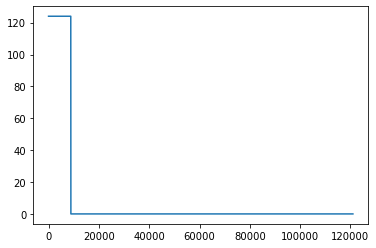

In [11]:
plt.plot(soc)

In [14]:
df5 = df3.copy()

load = df5['Load'].values
dg0 = df5['engMdoPower_0_'].values
dg1 = df5['engMdoPower_1_'].values
dg2 = df5['engMdoPower_2_'].values
dg3 = df5['engMdoPower_3_'].values
bat = df5['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%)
opid = df5['operationId'].values

for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 2100 and opid[i] != 6: 
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]*1.08
        soc[i+1] = soc[i] - bat[i]/720
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] > 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]

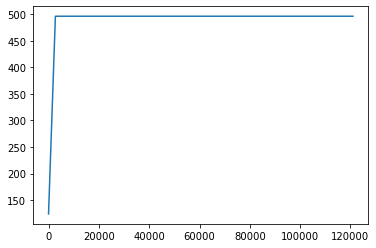

In [15]:
plt.plot(soc)

In [16]:
fc = (0.238*dg0)/720 + (0.238*dg1)/720
sum_fc = sum(fc)
sum_fc

41125.99943074074